# Installing and importing dependencies

In [ ]:
!pip install torch

In [ ]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision.datasets import CIFAR10
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import scipy
from collections.abc import Callable
from enum import Enum

def load_datasets(dataset, transform):
  train_dataset = dataset(root="../data",
                          train=True,
                          transform=transform,
                          download=True)
  test_dataset = dataset(root="../data",
                          train=False,
                          transform=transform)
  return (train_dataset, test_dataset)

In [ ]:
torch.cuda.is_available()

True

## importing FashionMnist and CIFAR10


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: torch.flatten(x))
    ])
mnist_train, mnist_test = load_datasets(FashionMNIST, transform)
cifar_train, cifar_test = load_datasets(CIFAR10, transform)

Files already downloaded and verified


# Models

## Activation functions

In [ ]:
def ReLU(x:np.ndarray)->np.ndarray:
    res = np.maximum(x, 0)
    return res

def ReLU_deriv(x:np.ndarray)->np.ndarray:
  return np.where(x >= 0, 1, 0)

# def sigmoid(x:np.ndarray)->np.ndarray:
#   return scipy.special.expit(x)

# def sigmoid_deriv(x:np.ndarray)->np.ndarray:
#   res = sigmoid(x)
#   return res * (1 - res)

def softmax(x:np.ndarray)->np.ndarray:
  """
    does row wise softmax or vector softmax ow
  """
  # do simple softmax
  if x.ndim !=2 or x.shape[0] == 1:
    max = np.max(x)
    exp = np.exp(x - max)
    return exp / np.sum(exp)
  # do row wise softmax
  max = np.max(x, axis = 1)[:, None]
  exp = np.exp(x - max)
  return exp / np.sum(exp, axis = 1)[:, None]


## MLP

In [ ]:
class MLP:
  class Initializers(Enum):
    ZERO = 0
    UNIFORM = 1
    GAUSSIAN = 2
    XAVIER = 3
    KAIMING = 4

  class Regularization(Enum):
    NONE=0
    L1=1
    L2=2

  def __init__(self, input_size, ouput_size, hidden_layers_widths:list[int]=[2, 2], epoch_length=250, epoch_offset_no_history=200,
               hidden_activation_function=ReLU, hidden_activation_function_deriv=ReLU_deriv, output_activation_function=softmax, mu = 0, std_dev = 0.01,
               initializer:Initializers=Initializers.GAUSSIAN, regularization:Regularization=Regularization.NONE, regularization_coeficient_w:float=0, regularization_coeficients_v:list[float]=[0, 0]) -> None:

    # initiliazters for weights
    initializers = [
        lambda r, c: [np.zeros((r, c)), np.zeros((1, c))],
        lambda r, c: [np.random.uniform(-1, 1, (r, c)), np.random.uniform(-1, 1,(1, c))],
        lambda r, c: [np.random.normal(mu, std_dev, size = (r, c)), np.random.normal(mu, std_dev, size=(1, c))],
        lambda r, c: [np.random.uniform(-1 / np.sqrt(r), 1 / np.sqrt(r), (r, c)), np.random.uniform(-1 / np.sqrt(r), 1 / np.sqrt(r), (1, c))],
        lambda r, c: [np.random.randn(r, c) * np.sqrt(2 / r), np.zeros((1, c))]
    ]

    # activation functions
    self.h = hidden_activation_function
    self.h_p = hidden_activation_function_deriv
    self.g = output_activation_function

    # regularization
    self.regularization = regularization
    if self.regularization != MLP.Regularization.NONE:
      assert len(regularization_coeficients_v) == len(hidden_layers_widths), f"number of regulariation weights mismatch with the number of hidden layers, regularization_coeficients_v = {len(regularization_coeficients_v)}, hidden_layers_widths = {len(hidden_layers_widths)}"
      self.regularization_coeficient_w = regularization_coeficient_w
      self.regularization_coeficients_v = regularization_coeficients_v

    # sizes
    self.D = input_size
    self.C = ouput_size

    # misc.
    self.epoch_length = epoch_length
    self.epoch_offset_no_history = epoch_offset_no_history

    # initialize w bw
    initializer = initializers[initializer.value]
    if len(hidden_layers_widths) == 0:
      self.w, self.bw = initializer(self.D, self.C)
    else:
      self.w, self.bw = initializer(hidden_layers_widths[-1], self.C)

    # initialize v bv
    self.v_bv_list = []

    # this will have shape [[matrix,bias], [matrix, bias], ...]
    for layer_index in range(len(hidden_layers_widths)):
      if layer_index == 0:
        v_bv = initializer(self.D, hidden_layers_widths[layer_index])
        self.v_bv_list.append(v_bv)
        continue
      v_bv = initializer(hidden_layers_widths[layer_index-1], hidden_layers_widths[layer_index])
      self.v_bv_list.append(v_bv)

  def predict(self, x:np.ndarray)->np.ndarray:
    """
      Returns models best prediction on the label of x.
    """
    if x.ndim != 2:
      x = x[None, :]
    assert x.shape[1] == self.D, f"input x's shape does not fit the required shape for this model, {x.shape[1]} != {self.D}"

    z = x
    for v_bv in self.v_bv_list:
      z = self.h(np.dot(z, v_bv[0]) + v_bv[1])

    z = self.g(np.dot(z, self.w) + self.bw)
    return z

  def cost(self, x:np.ndarray, y:np.ndarray):
    if x.ndim != 2:
      x = x[None, :]
      y = y[None, :]

    assert x.shape[1] == self.D, f"input x's shape does not fit the required shape for this model, {x.shape[1]} != {self.D}"
    assert y.shape[1] == self.C, f"input y's shape does not fit the required shape for this model, {y.shape[1]} != {self.C}"

    yh = self.predict(x)
    cross_entropy = - np.mean(np.sum(y * np.log(yh), axis=1))
    if self.regularization == MLP.Regularization.NONE:
      return cross_entropy

    cross_entropy += self.regularization_coeficient_w / 2. * np.linalg.norm(self.w) if self.regularization == MLP.Regularitation.L2 else \
      self.regularization_coeficient_w * np.linalg.norm(self.w, ord=1)

    for index, (v,_) in enumerate(self.v_bv_list):
      cross_entropy += self.regularization_coeficients_v[index] / 2. * np.linalg.norm(v) if self.regularization == MLP.Regularitation.L2 else \
        self.regularization_coeficients_v[index] * np.linalg.norm(v, ord=1)

    return cross_entropy

  def get_acc(self, x, y):
    if x.ndim != 2:
      x = x[None, :]
      y = y[None, :]
    yh = self.predict(x)
    col_range = range(1, self.C+1)
    y_dataframe = pd.Categorical(pd.DataFrame(y, columns=col_range).idxmax(1), categories=col_range)
    yh_dataframe = pd.Categorical(pd.DataFrame(yh, columns=col_range).idxmax(1), categories = col_range)
    confusion_matrix = pd.crosstab(yh_dataframe, y_dataframe, colnames=['Actual'],
                                        rownames=['Predicted'], margins=True, dropna=False)
    accuracy = confusion_matrix.iloc[:-1, :-1].to_numpy().diagonal().sum(dtype = 'float64') / \
                        confusion_matrix.iloc[-1, :-1].to_numpy().sum(dtype= 'float64')
    return accuracy


  def fit(self, x, y, max_iters=1e3, learning_rate=1e-4, batch_size=64, x_test = None, y_test = None):
    if x.ndim != 2:
      x = x[None, :]
      y = y[None, :]

    assert x.shape[1] == self.D, f"input x's shape does not fit the required shape for this model, {x.shape[1]} != {self.D}"
    assert y.shape[1] == self.C, f"input y's shape does not fit the required shape for this model, {y.shape[1]} != {self.C}"

    def gradient(x, y, w, bw, v_bv_list):
      """
        return dv_dbv in the same order as in the v_bv_list please.
      """

      N,_ = x.shape

      # will contain terms we need to do back propagation
      non_h_terms = [] # terms of the form y=Vz+b
      h_terms = [] # terms of the form z=h(y), including x at the start

      z = x
      h_terms.append(x)

      for v, bv in v_bv_list:
        a_non_h = np.dot(z, v) + bv
        a_h_term = self.h(a_non_h)

        non_h_terms.append(a_non_h)
        h_terms.append(a_h_term)

        z = a_h_term


      yh = self.g(np.dot(z, w) + bw)

      temp_deriv = yh - y

      dbw = np.dot(np.ones((1, N)), temp_deriv) / N
      dw = np.dot(h_terms.pop().T, temp_deriv) / N

      # Regularization
      if self.regularization != MLP.Regularization.NONE:
        dw += self.regularization_coeficient_w * w if self.regularization == MLP.Regularization.L2 else \
          self.regularization_coeficient_w * np.sign(w)

      dv_dbv = []

      for index in range(len(v_bv_list)):
        if index == 0:
          temp_deriv = np.dot(temp_deriv, w.T) * self.h_p(non_h_terms.pop())
        else:
          [v, bv] = v_bv_list[-index]
          temp_deriv = np.dot(temp_deriv, v.T) * self.h_p(non_h_terms.pop())

        dbv = np.dot(np.ones((1, N)), temp_deriv) / N
        dv = np.dot(h_terms.pop().T, temp_deriv) / N

        # Regularization
        if self.regularization == MLP.Regularization.L2:
          dv += self.regularization_coeficients_v[-index-1] * v_bv_list[-index-1][0]
        if self.regularization == MLP.Regularization.L1:
          dv += self.regularization_coeficients_v[-index-1] * np.sign(v_bv_list[-index-1][0])

        dv_dbv.insert(0,[dv, dbv])

      return [dw, dbw], dv_dbv

    N,_ = x.shape
    batch_size = min(batch_size, N)

    self.history_iter = []
    self.history_accuracy = []
    self.history_accuracy_test = []

    for iter in range(max_iters):
      s = np.random.randint(N, size = batch_size)
      x_p = x[s,:]
      y_p = y[s,:]

      [gw, gbw], gv_gbv = gradient(x_p, y_p, self.w, self.bw, self.v_bv_list)

      self.w = self.w - learning_rate * gw
      self.bw = self.bw - learning_rate * gbw

      for index, [gv, gbv] in enumerate(gv_gbv):
        self.v_bv_list[index][0] = self.v_bv_list[index][0] - learning_rate * gv
        self.v_bv_list[index][1] = self.v_bv_list[index][1] - learning_rate * gbv


      if iter >= self.epoch_offset_no_history and iter % self.epoch_length == 0:
        # print("+"*100)
        # print(f"\t current cost at iteration {iter:5d} : {self.cost(x, y):.4f}")
        # print(f"\t current accuracy {iter:5d} : {self.get_acc(x, y) * 100:.2f}%")
        # if x_test is not None :
        #   print(f"\t current accuracy on test set at {iter:5d} : {self.get_acc(x_test, y_test) * 100:.2f}%")
        # print("+"*100)
        self.history_iter.append(iter)
        self.history_accuracy.append(self.get_acc(x, y) * 100)
        if x_test is not None:
          self.history_accuracy_test.append(self.get_acc(x_test, y_test) * 100)
    return self




# Task 3

## Helpers


In [ ]:
def get_x_y(train, test):
  """
    takes pytorch train and test datasets and returns numpy x, y and x_test, y_test
  """
  x = np.vstack([train[index][0].numpy() for index in range(len(train))])
  x_mean = np.mean(x, axis = 0)
  x_deviation = np.std(x, axis = 0)
  x_unormalized = np.copy(x)
  x = (x - x_mean) / x_deviation
  y = np.hstack([train[index][1] for index in range(len(train))])
  y = pd.get_dummies(pd.DataFrame(y[:, None]).iloc[:,0]).to_numpy()

  x_test = np.vstack([test[index][0].numpy() for index in range(len(test))])
  x_test_unormalized = np.copy(x_test)
  x_test = (x_test - x_mean) / x_deviation
  y_test =  np.hstack([test[index][1] for index in range(len(test))])
  y_test = pd.get_dummies(pd.DataFrame(y_test[:, None]).iloc[:,0]).to_numpy()


  return [x, y], [x_test, y_test], [x_unormalized, x_test_unormalized]

[x_mnist, y_mnist], [x_mnist_test, y_mnist_test], [x_mnist_unormalized, x_mnist_test_unormalized] = get_x_y(mnist_train, mnist_test)


In [ ]:
EXPERIMENT_NUM_ITERATIONS = 20000

In [ ]:
class CNN(torch.nn.Module):
  def __init__(self, in_channels, in_width, out_size, kernel_size, fully_connected_widths=128):
    super(CNN, self).__init__()

    curr_width = in_width
    curr_chanels = in_channels

    self.conv1 = torch.nn.Conv2d(curr_chanels, curr_chanels * 2, kernel_size)

    curr_width = curr_width - kernel_size + 1
    curr_chanels = curr_chanels * 2

    self.conv2 = torch.nn.Conv2d(curr_chanels, curr_chanels * 2, kernel_size)

    curr_width = curr_width - kernel_size + 1
    curr_chanels = curr_chanels * 2

    self.input_to_linear_size = curr_chanels * curr_width ** 2

    self.fc1 = torch.nn.Linear(self.input_to_linear_size, fully_connected_widths)

    self.fc2 = torch.nn.Linear(fully_connected_widths, fully_connected_widths)

    self.fc3 = torch.nn.Linear(fully_connected_widths, out_size)

  def forward(self, x):
    # Conv
    x = torch.nn.functional.relu(self.conv1(x))
    x = torch.nn.functional.relu(self.conv2(x))

    # flatten
    x = x.view(-1, self.input_to_linear_size)

    # MLP
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = self.fc3(x)

    return x

  def get_acc(self,test_loader, device):
    with torch.no_grad():
      n_correct = 0
      n_samples = 0

      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = self(images)
          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()

      acc = 100.0 * n_correct / n_samples
    return acc

## Experiment 1

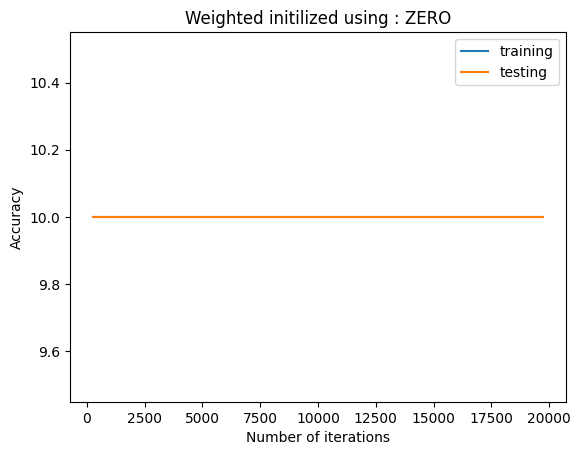

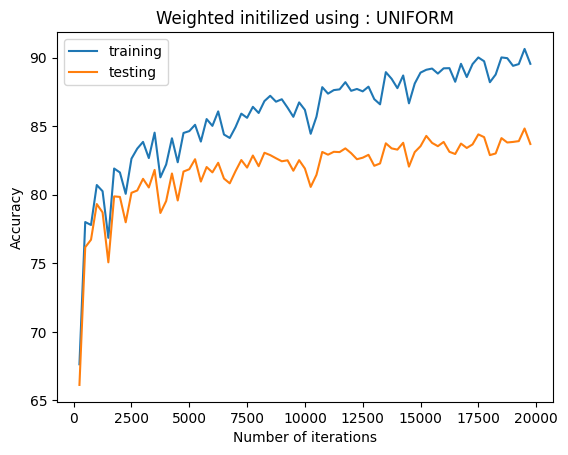

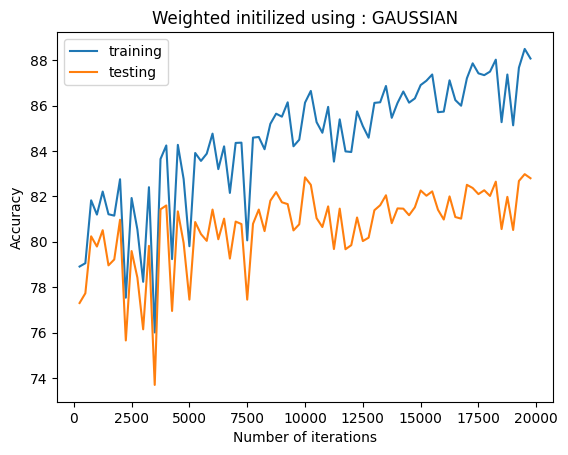

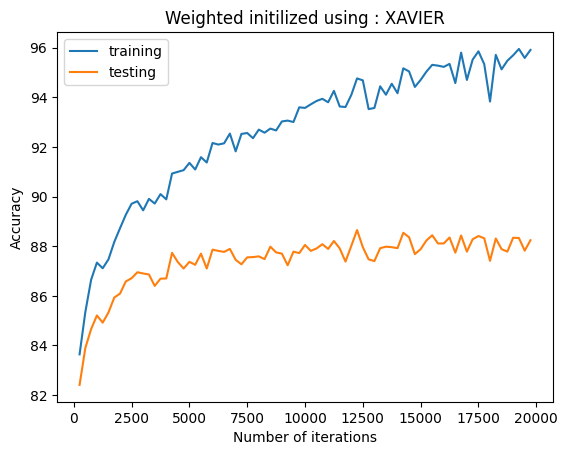

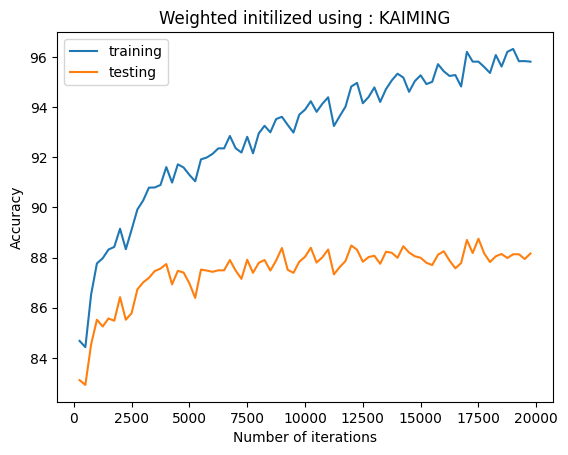

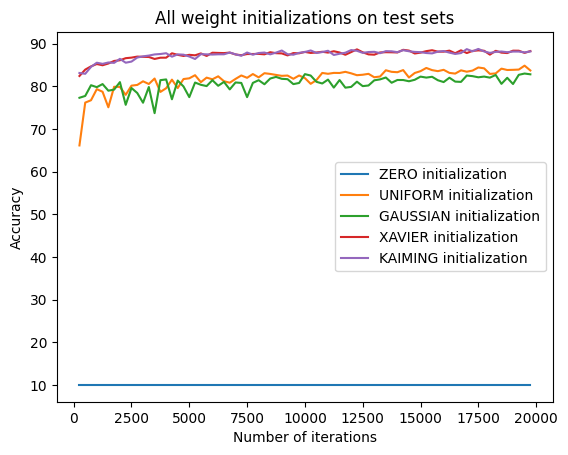

In [ ]:
def experiment_1():


  intitializers_names = []
  test_accuracies = []
  for initializer in list(MLP.Initializers):
    model = MLP(28*28, 10, hidden_layers_widths=[128], mu = 0, std_dev=1, initializer=initializer)
    model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)


    plt.plot(model.history_iter, model.history_accuracy, label="training")
    plt.plot(model.history_iter, model.history_accuracy_test, label="testing")

    test_accuracies.append(model.history_accuracy_test)
    plt.title(f"Weighted initilized using : {initializer.name}")
    plt.xlabel("Number of iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

  for initializer in list(MLP.Initializers):
    plt.plot(model.history_iter, test_accuracies[initializer.value], label=f"{initializer.name} initialization")
  plt.title("All weight initializations on test sets")
  plt.xlabel("Number of iterations")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()



experiment_1()

## Experiment 2

Using Kaiming because it seemed to do pretty well in experiment 1

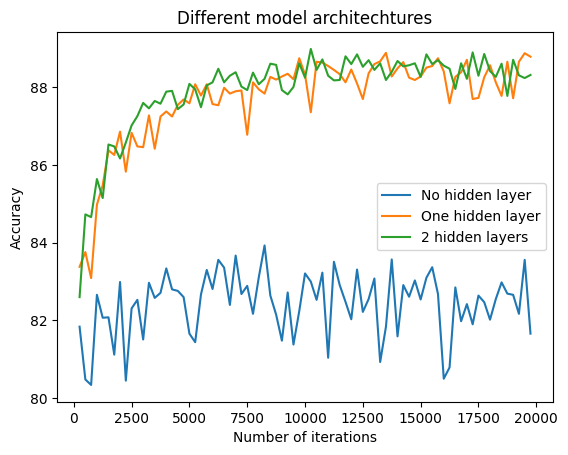

In [ ]:
def experiment_2():
  model = MLP(28*28, 10, hidden_layers_widths=[], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING)
  model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="No hidden layer")


  model = MLP(28*28, 10, hidden_layers_widths=[128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING)
  model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="One hidden layer")

  model = MLP(28*28, 10, hidden_layers_widths=[128, 128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING)
  model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)

  plt.plot(model.history_iter, model.history_accuracy_test, label="2 hidden layers")
  plt.title("Different model architechtures")
  plt.xlabel("Number of iterations")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


experiment_2()

## Experiment 3

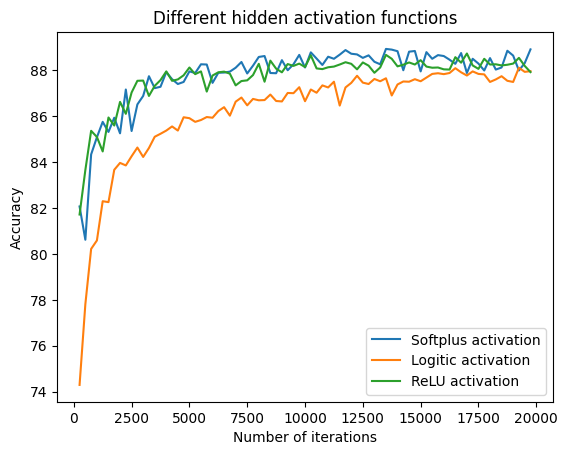

In [ ]:
def experiment_3():
  logistic = lambda x: 1/(1 + np.exp(-x))
  logistic_p = lambda x:(logistic(x))*(1-logistic(x))

  softplus = lambda x: np.log(1 + np.exp(x))
  softplus_p = lambda x: np.exp(x)/(1 + np.exp(x))

  model = MLP(28*28, 10, hidden_layers_widths=[128, 128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING, hidden_activation_function=softplus, hidden_activation_function_deriv=softplus_p)
  model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="Softplus activation")

  model = MLP(28*28, 10, hidden_layers_widths=[128, 128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING, hidden_activation_function=logistic, hidden_activation_function_deriv=logistic_p)
  model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="Logitic activation")

  model = MLP(28*28, 10, hidden_layers_widths=[128, 128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING)
  model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="ReLU activation")

  plt.title("Different hidden activation functions")
  plt.xlabel("Number of iterations")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()



experiment_3()


## Experiment 4

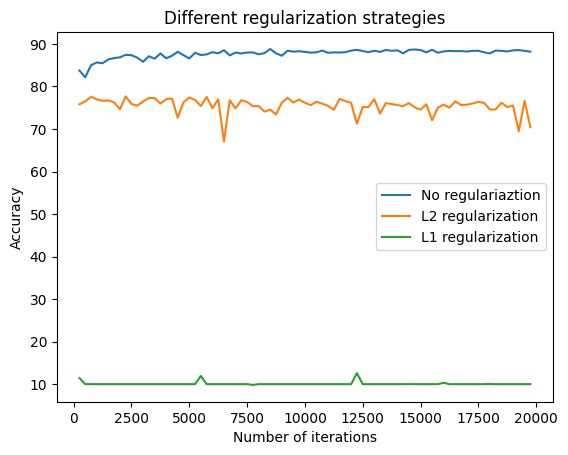

In [ ]:
def experiment_4():


  model = MLP(28*28, 10, hidden_layers_widths=[128, 128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING)
  model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="No regulariaztion")

  w_regularization_coef = 0.1
  v_regularization_coefs = [0.1] * 2


  model = MLP(28*28, 10, hidden_layers_widths=[128, 128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING, regularization=MLP.Regularization.L2,
              regularization_coeficient_w=w_regularization_coef, regularization_coeficients_v=v_regularization_coefs)
  model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="L2 regularization")


  model = MLP(28*28, 10, hidden_layers_widths=[128, 128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING, regularization=MLP.Regularization.L1,
              regularization_coeficient_w=w_regularization_coef, regularization_coeficients_v=v_regularization_coefs)
  model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="L1 regularization")


  plt.title("Different regularization strategies")
  plt.xlabel("Number of iterations")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

experiment_4()

## Experiment 5

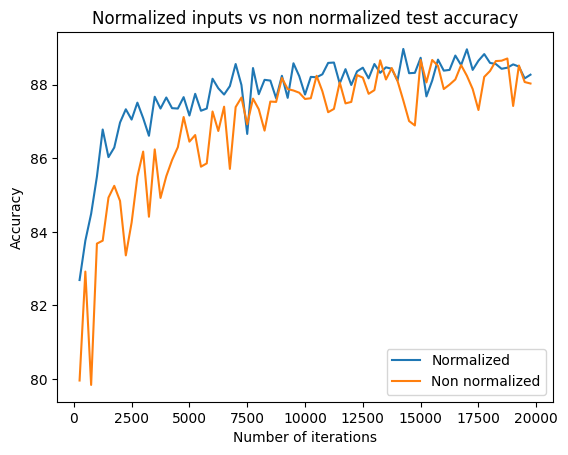

In [ ]:
def experiment_5():

  model = MLP(28*28, 10, hidden_layers_widths=[128, 128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING)
  model.fit(x_mnist, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test, y_test=y_mnist_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="Normalized")

  model = MLP(28*28, 10, hidden_layers_widths=[128, 128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING)
  model.fit(x_mnist_unormalized, y_mnist, max_iters=EXPERIMENT_NUM_ITERATIONS, learning_rate=1e-1, batch_size=64, x_test=x_mnist_test_unormalized, y_test=y_mnist_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="Non normalized")


  plt.title("Normalized inputs vs non normalized test accuracy")
  plt.xlabel("Number of iterations")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

experiment_5()


## Experiment 6

[Inspired from](https://github.com/patrickloeber/pytorchTutorial/blob/master/14_cnn.py)

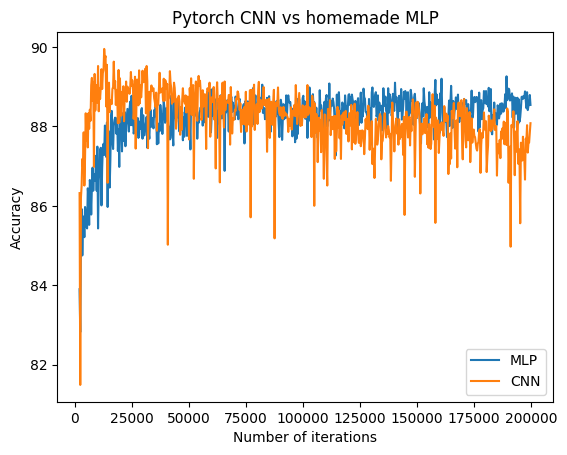

In [ ]:
def experiment_6():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

  mnist_train, mnist_test = load_datasets(FashionMNIST, transform)

  batch_size = 32

  max_iters = 200000

  learning_rate = 1e-1

  epoch_offset = 2000
  epoch_len = 300

  # MLP
  x = np.vstack([mnist_train[index][0].numpy().flatten() for index in range(len(mnist_train))])
  y = np.hstack([mnist_train[index][1] for index in range(len(mnist_train))])
  y = pd.get_dummies(pd.DataFrame(y[:, None]).iloc[:,0]).to_numpy()

  x_test = np.vstack([mnist_test[index][0].numpy().flatten() for index in range(len(mnist_test))])

  y_test =  np.hstack([mnist_test[index][1] for index in range(len(mnist_test))])
  y_test = pd.get_dummies(pd.DataFrame(y_test[:, None]).iloc[:,0]).to_numpy()

  model = MLP(28*28, 10, hidden_layers_widths=[128, 128], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING, epoch_offset_no_history=epoch_offset, epoch_length=epoch_len)
  model.fit(x, y, max_iters=max_iters, learning_rate=1e-1, batch_size=batch_size, x_test=x_test, y_test=y_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="MLP")


  # CNN
  train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                            shuffle=True)

  test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                          shuffle=False)

  model = CNN(1, 28, len(mnist_train.classes), 3).to(device)
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), learning_rate)

  iteration = 0
  iteration_list = []
  test_acc_list = []
  # CNN Learning
  while iteration < max_iters:
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      iteration += 1
      if iteration >= epoch_offset and iteration % epoch_len == 0:
          iteration_list.append(iteration)
          test_acc_list.append(model.get_acc(test_loader, device))
      if iteration >= max_iters:
        break

  plt.plot(iteration_list, test_acc_list, label="CNN")

  # Plotting
  plt.title("Pytorch CNN vs homemade MLP")
  plt.xlabel("Number of iterations")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

experiment_6()

## Experiment 7

Files already downloaded and verified


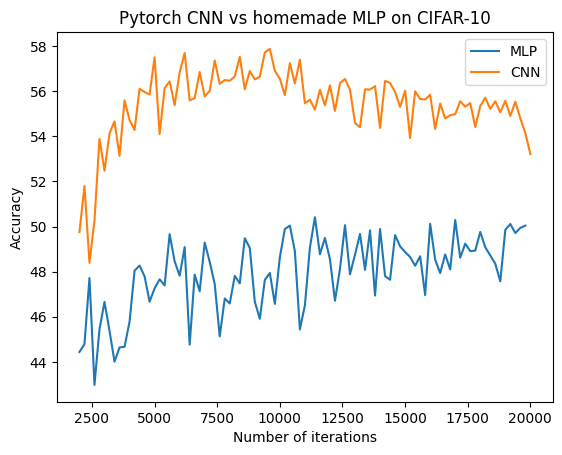

In [ ]:
def experiment_7():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  cifar_train, cifar_test = load_datasets(CIFAR10, transform)

  batch_size = 32
  # 9 mins for 10000 iterations
  max_iters = 20000

  learning_rate = 1e-1

  epoch_offset = 2000
  epoch_len = 200

  # MLP
  x = np.vstack([cifar_train[index][0].numpy().flatten() for index in range(len(cifar_train))])
  y = np.hstack([cifar_train[index][1] for index in range(len(cifar_train))])
  y = pd.get_dummies(pd.DataFrame(y[:, None]).iloc[:,0]).to_numpy()

  x_test = np.vstack([cifar_test[index][0].numpy().flatten() for index in range(len(cifar_test))])

  y_test =  np.hstack([cifar_test[index][1] for index in range(len(cifar_test))])
  y_test = pd.get_dummies(pd.DataFrame(y_test[:, None]).iloc[:,0]).to_numpy()

  model = MLP(32*32*3, len(cifar_train.classes), hidden_layers_widths=[128 * 3], mu = 0, std_dev=1, initializer=MLP.Initializers.KAIMING, epoch_offset_no_history=epoch_offset, epoch_length=epoch_len)
  model.fit(x, y, max_iters=max_iters, learning_rate=learning_rate, batch_size=batch_size, x_test=x_test, y_test=y_test)
  plt.plot(model.history_iter, model.history_accuracy_test, label="MLP")


  # CNN
  train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                            shuffle=True)

  test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                          shuffle=False)

  model = CNN(3, 32, len(cifar_train.classes), 3).to(device)
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), learning_rate)

  iteration = 0
  iteration_list = []
  test_acc_list = []
  # CNN Learning
  while iteration < max_iters:
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      iteration += 1
      if iteration >= epoch_offset and iteration % epoch_len == 0:
          iteration_list.append(iteration)
          test_acc_list.append(model.get_acc(test_loader, device))
      if iteration >= max_iters:
        break

  plt.plot(iteration_list, test_acc_list, label="CNN")

  # Plotting
  plt.title("Pytorch CNN vs homemade MLP on CIFAR-10")
  plt.xlabel("Number of iterations")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

experiment_7()

## Experiment 8

Files already downloaded and verified


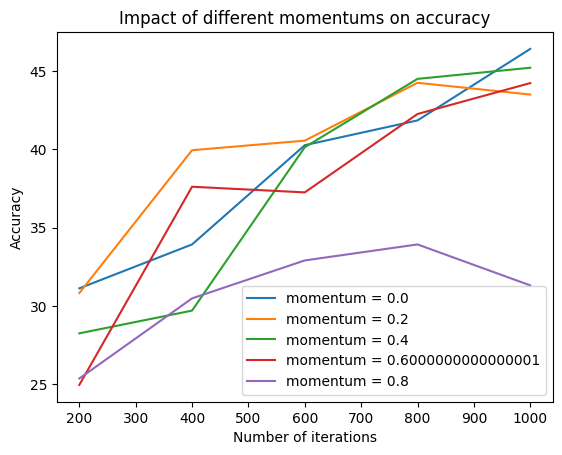

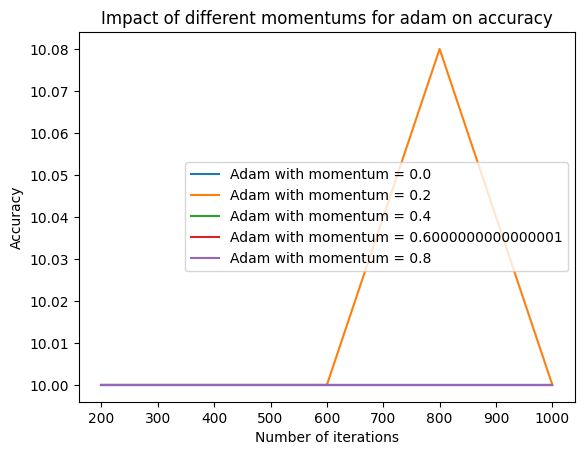

In [ ]:
def experiment_8():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  cifar_train, cifar_test = load_datasets(CIFAR10, transform)

  batch_size = 32
  # 9 mins for 10000 iterations
  max_iters = 1000

  learning_rate = 1e-1

  epoch_offset = 0
  epoch_len = 200

  # CNN
  train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                            shuffle=True)

  test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                          shuffle=False)

  for momentum_factor_num in range(0, 9, 2):
    momentum_factor = momentum_factor_num * 0.1
    model = CNN(3, 32, len(cifar_train.classes), 3).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=momentum_factor)

    iteration = 0
    iteration_list = []
    test_acc_list = []
    # CNN Learning
    while iteration < max_iters:
      for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iteration += 1
        if iteration >= epoch_offset and iteration % epoch_len == 0:
            iteration_list.append(iteration)
            test_acc_list.append(model.get_acc(test_loader, device))
        if iteration >= max_iters:
          break

    plt.plot(iteration_list, test_acc_list, label=f"momentum = {momentum_factor}")

  plt.title("Impact of different momentums on accuracy")
  plt.xlabel("Number of iterations")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  for momentum_factor_num in range(0, 9, 2):
    momentum_factor = momentum_factor_num * 0.1

    model = CNN(3, 32, len(cifar_train.classes), 3).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate, (momentum_factor,0.999))
    iteration = 0
    iteration_list = []
    test_acc_list = []
    # CNN Learning
    while iteration < max_iters:
      for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iteration += 1
        if iteration >= epoch_offset and iteration % epoch_len == 0:
            iteration_list.append(iteration)
            test_acc_list.append(model.get_acc(test_loader, device))
        if iteration >= max_iters:
          break

    plt.plot(iteration_list, test_acc_list, label=f"Adam with momentum = {momentum_factor}")

  # Plotting
  plt.title("Impact of different momentums for adam on accuracy")
  plt.xlabel("Number of iterations")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

experiment_8()
